## STMO Project

In [42]:
!pip install osmnx networkx

In [43]:
import osmnx as ox
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
from time import time

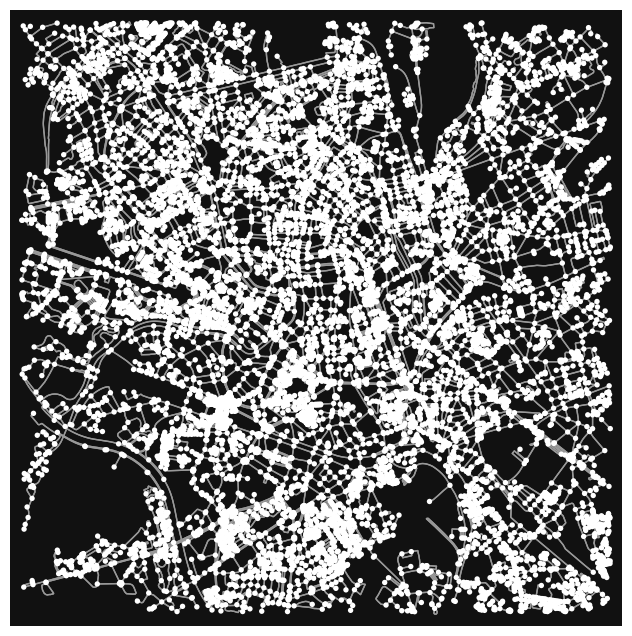

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [44]:
# Define the address as a starting point
address = "Sint-kwintensberg 74, Ghent, Belgium"

# Geocode the address to get its latitude and longitude
center_point = ox.geocode(address)

# Define the buffer distance (in meters) for the map area
buffer_distance = 3000  # 2 km radius

# Download the street network data within the buffer distance around the center point
graph = ox.graph_from_point(center_point, dist=buffer_distance, network_type='walk')
graph = ox.distance.add_edge_lengths(graph)

# Plot the graph to verify
ox.plot_graph(graph)

In [45]:
def calculate_route_length(graph, route):
    """
    Calculate the total length of a given route.

    Parameters:
    - graph: NetworkX graph object.
    - route: List of nodes representing the path.

    Returns:
    - Total length of the route in meters.
    """
    length = 0
    for u, v in zip(route[:-1], route[1:]):
        edge_data = graph.get_edge_data(u, v, default={})
        if isinstance(edge_data, dict):
            length += edge_data[0]["length"]  # Edge length in meters
    return length

def simulated_annealing_with_addresses(graph, start_address, end_address, distance, max_iterations=1000, initial_temp=1000, cooling_rate=0.003):
    """
    Perform simulated annealing to find an approximate path between two addresses with a given distance constraint.

    Parameters:
    - graph: A network graph object (from OSMnx).
    - start_address: Starting address as a string.
    - end_address: Ending address as a string.
    - distance: Desired approximate distance for the route (in meters).
    - max_iterations: Maximum number of iterations (default=1000).
    - initial_temp: Starting temperature for the annealing process (default=1000).
    - cooling_rate: Cooling rate for the temperature (default=0.003).

    Returns:
    - best_route: The best route found.
    - best_length: The length of the best route.
    """
    def get_random_neighbor(route):
        """
        Generate a random neighbor by modifying the route.
        Ensures the neighbor is valid for the graph.
        """
        new_route = route[:]
        if len(route) > 2:
            idx1, idx2 = random.sample(range(1, len(route) - 1), 2)  # Avoid swapping start/end nodes
            new_route[idx1], new_route[idx2] = new_route[idx2], new_route[idx1]
        return new_route

    # Geocode addresses to get their corresponding nodes
    start_point = ox.geocode(start_address)
    end_point = ox.geocode(end_address)
    start_node = ox.nearest_nodes(graph, start_point[1], start_point[0])
    end_node = ox.nearest_nodes(graph, end_point[1], end_point[0])

    # Initialize the route as the shortest path between start and end nodes
    current_route = nx.shortest_path(graph, start_node, end_node, weight='length')
    current_length = calculate_route_length(graph, current_route)

    best_route = current_route
    best_length = current_length
    temperature = initial_temp

    for i in range(max_iterations):
        # Generate a neighbor route
        new_route = get_random_neighbor(current_route)
        try:
            new_length = calculate_route_length(graph, new_route)
        except Exception:
            continue  # Skip invalid routes

        # Calculate penalty for deviation from target distance
        current_penalty = abs(current_length - distance)
        new_penalty = abs(new_length - distance)

        # Acceptance condition: prioritize routes closer to the target distance
        delta_penalty = new_penalty - current_penalty

        if delta_penalty < 0 or np.exp(-delta_penalty / temperature) > random.random():
            current_route = new_route
            current_length = new_length

            # Update the best route if the new one is closer to the desired distance
            if abs(current_length - distance) < abs(best_length - distance):
                best_route = current_route
                best_length = current_length

        # Cool down the temperature
        temperature *= (1 - cooling_rate)

    return best_route, best_length

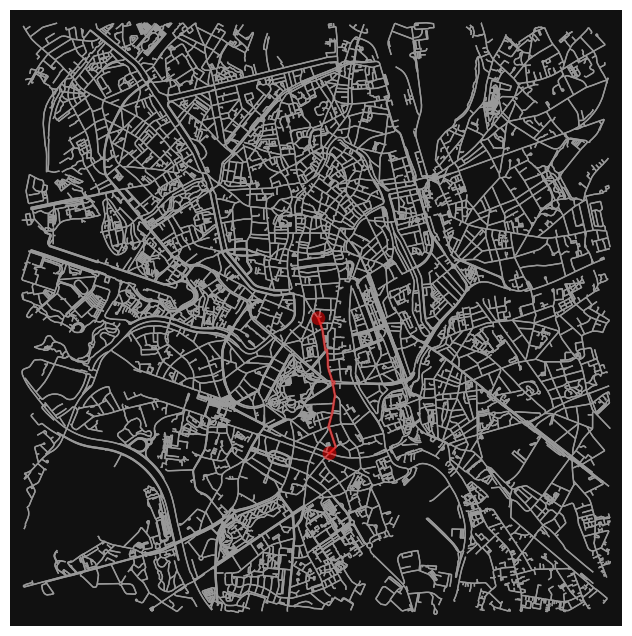

1493.357931602231


In [46]:
# Define the start point (latitude, longitude) and desired distance in meters
distance = 2000  # 5 kilometers

# Run the simulated annealing algorithm
best_route, best_length = simulated_annealing_with_addresses(graph, 'Sint-kwintensberg 74, Ghent, Belgium', "Burggravenlaan 327, Ghent, Belgium" , distance)

# Plot the optimized route
fig, ax = ox.plot_graph_route(graph, best_route, route_linewidth=2, node_size=0)
plt.show()
print(best_length)

In [47]:
# Test Shortest Path
# Verify the connectivity and the shortest path between the start and end points before running brute force.
start_address = "Sint-kwintensberg 74, Ghent, Belgium"
end_address = "Burggravenlaan 327, Ghent, Belgium"

# Geocode the addresses
start_point = ox.geocode(start_address)
end_point = ox.geocode(end_address)

# Find the nearest nodes
start_node = ox.nearest_nodes(graph, start_point[1], start_point[0])
end_node = ox.nearest_nodes(graph, end_point[1], end_point[0])

# Check connectivity
if not nx.has_path(graph, start_node, end_node):
    print("No path exists between the start and end nodes.")
else:
    # Calculate the shortest path
    shortest_path = nx.shortest_path(graph, source=start_node, target=end_node, weight="length")
    shortest_length = sum(graph[u][v][0]["length"] for u, v in zip(shortest_path[:-1], shortest_path[1:]))
    print(f"Shortest path length: {shortest_length} meters")

Shortest path length: 1493.357931602231 meters


In [48]:
def brute_force_with_neighbors(graph, start_address, end_address, target_distance, neighbor_depth=1):
    """
    Find the best route between two addresses by exploring deviations 
    from the shortest path and evaluating candidates.

    Parameters:
    - graph: NetworkX graph object.
    - start_address: Start location as a string (address).
    - end_address: End location as a string (address).
    - target_distance: Desired route length in meters.
    - neighbor_depth: Depth to explore deviations from the shortest path.

    Returns:
    - best_route: The best route (list of nodes).
    - best_length: Length of the best route in meters.
    """
    # Geocode addresses and find nearest nodes
    start_point = ox.geocode(start_address)
    end_point = ox.geocode(end_address)
    start_node = ox.nearest_nodes(graph, start_point[1], start_point[0])
    end_node = ox.nearest_nodes(graph, end_point[1], end_point[0])

    print(f"Start node: {start_node}, End node: {end_node}")

    # Verify connectivity
    if not nx.has_path(graph, start_node, end_node):
        print("No path exists between the start and end nodes.")
        return None, None

    # Compute the shortest path
    shortest_path = nx.shortest_path(graph, source=start_node, target=end_node, weight="length")
    shortest_length = calculate_route_length(graph, shortest_path)
    print(f"Shortest path length: {shortest_length:.2f} meters")

    # Explore deviations from the shortest path
    candidate_routes = [shortest_path]
    for node in shortest_path[1:-1]:  # Skip start and end nodes
        for neighbor in graph.neighbors(node):
            try:
                # Combine paths via neighbors
                alt_path = nx.shortest_path(graph, source=start_node, target=neighbor, weight="length")
                alt_path += nx.shortest_path(graph, source=neighbor, target=end_node, weight="length")[1:]
                candidate_routes.append(alt_path)
            except nx.NetworkXNoPath:
                continue

    # Evaluate all candidate routes
    best_route, best_length = None, float("inf")
    closest_distance_diff = float("inf")

    for route in candidate_routes:
        route_length = calculate_route_length(graph, route)
        distance_diff = abs(route_length - target_distance)

        # Update best route if closer to target distance
        if distance_diff < closest_distance_diff:
            best_route = route
            best_length = route_length
            closest_distance_diff = distance_diff

    return best_route, best_length

In [49]:
def load_graph(center_address, buffer_distance=3000):
    """
    Load the street network around a given location.

    Parameters:
    - center_address: Central address for the graph.
    - buffer_distance: Radius to download the graph (in meters).

    Returns:
    - graph: NetworkX graph object representing the walking network.
    """
    print("Loading graph...")
    center_point = ox.geocode(center_address)
    graph = ox.graph_from_point(center_point, dist=buffer_distance, network_type="walk")
    graph = ox.distance.add_edge_lengths(graph)  # Ensure edge lengths are included
    print(f"Graph loaded with {len(graph.nodes)} nodes and {len(graph.edges)} edges.")
    return graph

Loading graph...
Graph loaded with 12971 nodes and 35680 edges.
Finding best route...
Start node: 1970580017, End node: 247108130
Shortest path length: 973.46 meters
Best route found with length: 1227.93 meters


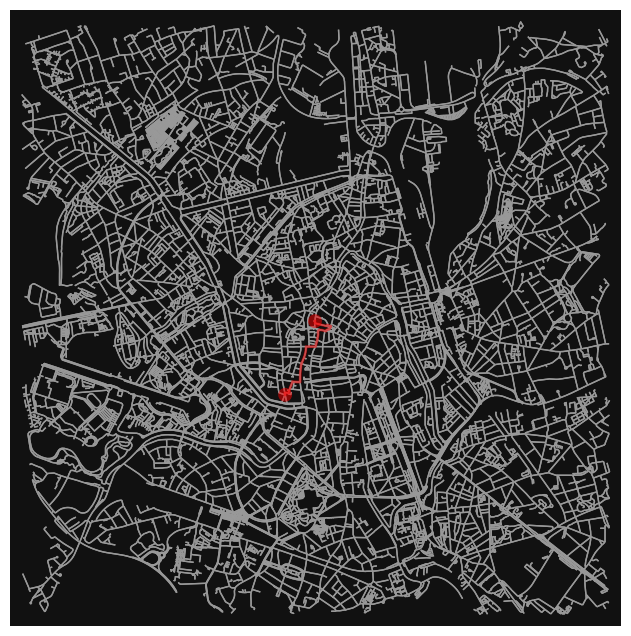

In [50]:
def main():
    """
    Main function to load the graph, compute the best route, and visualize it.
    """
    # Parameters
    start_address = "Korenmarkt, Ghent, Belgium"
    end_address = "Waarschootstraat 1, Ghent, Belgium"
    target_distance = 2000  # Desired route length (meters)
    buffer_distance = 3000  # Graph radius (meters)

    # Load graph
    graph = load_graph(start_address, buffer_distance)

    # Find the best route
    print("Finding best route...")
    best_route, best_length = brute_force_with_neighbors(
        graph, start_address, end_address, target_distance, neighbor_depth=2
    )

    # Display results
    if best_route:
        print(f"Best route found with length: {best_length:.2f} meters")
        fig, ax = ox.plot_graph_route(graph, best_route, route_linewidth=2, node_size=0)
        plt.show()
    else:
        print("No valid route found.")

if __name__ == "__main__":
    main()